In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,cross_validate
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor,VotingClassifier
from sklearn.preprocessing import MinMaxScaler,LabelEncoder, StandardScaler, RobustScaler
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression,LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
import gc
from sklearn.exceptions import ConvergenceWarning
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,VotingRegressor
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,roc_auc_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import classification_report

In [2]:
warnings.simplefilter("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
train_transaction=pd.read_csv('../input/ieee-fraud-detection/train_transaction.csv')
train_identity=pd.read_csv('../input/ieee-fraud-detection/train_identity.csv')
test_transaction=pd.read_csv('../input/ieee-fraud-detection/test_transaction.csv')
test_identity=pd.read_csv('../input/ieee-fraud-detection/test_identity.csv')
sample_submission=pd.read_csv('../input/ieee-fraud-detection/sample_submission.csv')

In [4]:
train_identity.shape

(144233, 41)

In [5]:
train_df = train_transaction.merge(train_identity, how="left", on="TransactionID")

test_df = test_transaction.merge(test_identity, how="left", on="TransactionID")

In [6]:
#train_df= train_df.rename(columns=lambda x:"".join(x.split("_")))
test_df= test_df.rename(columns=lambda x:"_".join(x.split("-")))
#test_df= test_df.rename(columns=lambda x:"".join(x.split("_")))


#### Reduce Memory

In [7]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [8]:
train_df = reduce_mem_usage(train_df)
test_df  = reduce_mem_usage(test_df)

Mem. usage decreased to 650.48 Mb (66.8% reduction)
Mem. usage decreased to 565.37 Mb (66.3% reduction)


#### Reduction Data

In [9]:
#train_df=train_df.sample(frac=0.2, random_state=3)

In [10]:
# cat_th=61 and car_th=74 we decided after eda.
def grab_col_names(dataframe, cat_th=61, car_th=74):
    """

    It gives the names of categorical, numerical and categorical but cardinal variables in the data set.
    Note: Categorical variables with numerical appearance are also included in categorical variables.

    Parameters
    ------
        dataframe: dataframe
                The dataframe from which variable names are to be retrieved
        cat_th: int, optional
                Class threshold value for numeric but categorical variables
        car_th: int, optinal
                Class threshold for categorical but cardinal variables

    Returns
    ------
        cat_cols: list
                Categorical variable list
        num_cols: list
                Numerical variable list
        cat_but_car: list
                Categorical view cardinal variable list

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = the total number of variables
        num_but_cat is inside cat_cols.
        The sum of 3 lists with return is equal to the total number of variables: cat_cols + num_cols + cat_but_car = number of variables

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f"cat_cols: {len(cat_cols)}")
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car

In [11]:
cat_cols, num_cols, cat_but_car =grab_col_names(train_df)

Observations: 590540
Variables: 434
cat_cols: 250
num_cols: 180
cat_but_car: 4
num_but_cat: 223


#### Some Outliers

In [12]:
# droptamt = train_df[train_df['TransactionAmt']>10000].index
# train_df.drop(droptamt, inplace=True)

# dropdist1 = train_df[train_df['dist1']>6000].index
# train_df.drop(dropdist1, inplace=True)

# dropdist2 = train_df[train_df['dist2']>8000].index
# train_df.drop(dropdist2, inplace=True)

# dropc1 = train_df[train_df['C1'] > 2000].index
# train_df.drop(dropc1, inplace=True)

# dropc2 = train_df[train_df['C2'] > 2000].index
# train_df.drop(dropc2, inplace=True)

# #dropping the -ve values
# dropd4 = train_df[train_df['D4']<0].index
# train_df.drop(dropd4, inplace=True)

# dropd6 = train_df[train_df['D6']<0].index
# train_df.drop(dropd6, inplace=True)

# dropd11 = train_df[train_df['D11']<0].index
# train_df.drop(dropd11, inplace=True)

# dropd12 = train_df[train_df['D12']<0].index
# train_df.drop(dropd12, inplace=True)

# dropd14 = train_df[train_df['D14']<0].index
# train_df.drop(dropd14, inplace=True)

# dropd15 = train_df[train_df['D15']<0].index
# train_df.drop(dropd15, inplace=True)

In [13]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    
    if na_name:
        return na_columns,missing_df

In [14]:
na_cols,missing_df=missing_values_table(train_df, True)
missing_df.reset_index(inplace=True)

               n_miss  ratio
id_24          585793  99.20
id_25          585408  99.13
id_07          585385  99.13
id_08          585385  99.13
id_21          585381  99.13
id_26          585377  99.13
id_27          585371  99.12
id_23          585371  99.12
id_22          585371  99.12
dist2          552913  93.63
D7             551623  93.41
id_18          545427  92.36
D13            528588  89.51
D14            528353  89.47
D12            525823  89.04
id_03          524216  88.77
id_04          524216  88.77
D6             517353  87.61
id_33          517251  87.59
id_10          515614  87.31
id_09          515614  87.31
D8             515614  87.31
D9             515614  87.31
id_30          512975  86.87
id_32          512954  86.86
id_34          512735  86.82
id_14          510496  86.45
V155           508595  86.12
V138           508595  86.12
V156           508595  86.12
V157           508595  86.12
V158           508595  86.12
V154           508595  86.12
V153          

#### Feature Engineering

In [15]:
def feature_eng(dataframe,name=True):
    
    def card3Values(val):
        if val==np.nan:
            return val
        else:
            if val > 150:
                return 'T'
            else:
                return 'F'
    
    dataframe['card3Values'] = dataframe['card3'].apply(card3Values)
    
    def replaceToOther(value):
        if value==np.nan:
            return value
        if value=='debit or credit' or value=='charge card':
            return 'debit'
        else:
            return value
     
    dataframe['card6'] = dataframe['card6'].apply(replaceToOther)
    
    def returnfirst(email):
        return email.split(".")[0]
    
    dataframe['first'] = dataframe[~dataframe['P_emaildomain'].isnull()]['P_emaildomain'].apply(returnfirst)
    
    emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum',
    'scranton.edu': 'other', 'optonline.net': 'other', 'hotmail.co.uk': 'microsoft', 'comcast.net': 'other', 'yahoo.com.mx': 'yahoo',
    'yahoo.fr': 'yahoo', 'yahoo.es': 'yahoo', 'charter.net': 'spectrum', 'live.com': 'microsoft', 'aim.com': 'aol', 'hotmail.de': 
    'microsoft', 'centurylink.net': 'centurylink', 'gmail.com': 'google', 'me.com': 'apple', 'earthlink.net': 'other', 'gmx.de': 'other', 
    'web.de': 'other', 'cfl.rr.com': 'other', 'hotmail.com': 'microsoft', 'protonmail.com': 'other',  'hotmail.fr': 'microsoft', 
    'windstream.net': 'other', 'outlook.es': 'microsoft', 'yahoo.co.jp': 'yahoo', 'yahoo.de': 'yahoo', 'servicios-ta.com': 'other', 
    'netzero.net': 'other', 'suddenlink.net': 'other', 'roadrunner.com': 'other', 'sc.rr.com': 'other', 'live.fr': 'microsoft', 
    'verizon.net': 'yahoo', 'msn.com': 'microsoft', 'q.com': 'centurylink', 'prodigy.net.mx': 'att', 'frontier.com': 'yahoo', 
    'anonymous.com': 'other', 'rocketmail.com': 'yahoo', 'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo', 'ymail.com': 'yahoo', 
    'outlook.com': 'microsoft', 'mail.com': 'other', 'bellsouth.net': 'other', 'embarqmail.com': 'centurylink', 'cableone.net': 'other', 
    'hotmail.es': 'microsoft', 'mac.com': 'apple', 'yahoo.co.uk': 'yahoo', 'netzero.com': 'other', 'yahoo.com': 'yahoo', 
    'live.com.mx': 'microsoft', 'ptd.net': 'other', 'cox.net': 'other', 'aol.com': 'aol', 'juno.com': 'other', 'icloud.com': 'apple'}
    us_emails = ['gmail', 'net', 'edu']
    
    for c in ['P_emaildomain', 'R_emaildomain']:
        dataframe[c + '_bin'] = dataframe[c].map(emails)
        dataframe[c + '_suffix'] = dataframe[c].map(lambda x: str(x).split('.')[-1])
        dataframe[c + '_suffix'] = dataframe[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')
    
    #since we have created 2 features now dropping the "first" columns
    dataframe.drop(['first'],axis=1,inplace=True)
    
    dataframe["new_domain"]=dataframe['P_emaildomain'].apply(lambda x:str(x).partition(".")[0])
    dataframe["new_domain1"]=dataframe['P_emaildomain'].apply(lambda x:str(x).partition(".")[-1])
    dataframe["new_domain2"]=dataframe['R_emaildomain'].apply(lambda x:str(x).partition(".")[-1])
    
    def id31_split(data):
        data['browser_id_31'] = data['id_31'].str.split(' ', expand=True)[0]
        data['version_id_31'] = data['id_31'].str.split(' ', expand=True)[1]

    id31_split(dataframe)
    
    def id30_split(data):
        data['OS_id_30'] = data['id_30'].str.split(' ', expand=True)[0]
        data['version_id_30'] = data['id_30'].str.split(' ', expand=True)[1]

    id30_split(dataframe)
    
    def id33_split(data):
        data['screen_width'] = data['id_33'].str.split('x', expand=True)[0]
        data['screen_height'] = data['id_33'].str.split('x', expand=True)[1]
        
    id33_split(dataframe)
    
    
    def afterDecimalCount(amt):
        amtString = str(amt)
        return len(amtString.split(".")[1])
    
    dataframe['TransDecimalCount'] = dataframe['TransactionAmt'].apply(afterDecimalCount)
    
    dataframe['device_version'] = dataframe['DeviceInfo'].str.split('/', expand=True)[1]
    
    dataframe['device_name'] = dataframe['DeviceInfo'].str.split('/', expand=True)[0]
    dataframe.loc[dataframe['device_name'].str.contains('SM', na=False), 'device_name'] = 'Samsung'
    dataframe.loc[dataframe['device_name'].str.contains('SAMSUNG', na=False), 'device_name'] = 'Samsung'
    dataframe.loc[dataframe['device_name'].str.contains('GT-', na=False), 'device_name'] = 'Samsung'
    dataframe.loc[dataframe['device_name'].str.contains('Moto G', na=False), 'device_name'] = 'Motorola'
    dataframe.loc[dataframe['device_name'].str.contains('Moto', na=False), 'device_name'] = 'Motorola'
    dataframe.loc[dataframe['device_name'].str.contains('moto', na=False), 'device_name'] = 'Motorola'
    dataframe.loc[dataframe['device_name'].str.contains('LG-', na=False), 'device_name'] = 'LG'
    dataframe.loc[dataframe['device_name'].str.contains('rv:', na=False), 'device_name'] = 'RV'
    dataframe.loc[dataframe['device_name'].str.contains('HUAWEI', na=False), 'device_name'] = 'Huawei'
    dataframe.loc[dataframe['device_name'].str.contains('ALE-', na=False), 'device_name'] = 'Huawei'
    dataframe.loc[dataframe['device_name'].str.contains('-L', na=False), 'device_name'] = 'Huawei'
    dataframe.loc[dataframe['device_name'].str.contains('Blade', na=False), 'device_name'] = 'ZTE'
    dataframe.loc[dataframe['device_name'].str.contains('BLADE', na=False), 'device_name'] = 'ZTE'
    dataframe.loc[dataframe['device_name'].str.contains('Linux', na=False), 'device_name'] = 'Linux'
    dataframe.loc[dataframe['device_name'].str.contains('XT', na=False), 'device_name'] = 'Sony'
    dataframe.loc[dataframe['device_name'].str.contains('HTC', na=False), 'device_name'] = 'HTC'
    dataframe.loc[dataframe['device_name'].str.contains('ASUS', na=False), 'device_name'] = 'Asus'

    dataframe.loc[dataframe.device_name.isin(dataframe.device_name.value_counts()[dataframe.device_name.value_counts() < 200].index), 'device_name'] = "Others"
    dataframe['had_id'] = "1"
    
    dataframe['TransactionAmt_to_mean_card1'] = dataframe['TransactionAmt'] / dataframe.groupby(['card1'])['TransactionAmt'].transform('mean')
    dataframe['TransactionAmt_to_mean_card4'] = dataframe['TransactionAmt'] / dataframe.groupby(['card4'])['TransactionAmt'].transform('mean')
    dataframe['TransactionAmt_to_std_card1'] = dataframe['TransactionAmt'] / dataframe.groupby(['card1'])['TransactionAmt'].transform('std')
    dataframe['TransactionAmt_to_std_card4'] = dataframe['TransactionAmt'] / dataframe.groupby(['card4'])['TransactionAmt'].transform('std')
    dataframe['TransactionAmt_to_std_addr1'] = dataframe['TransactionAmt'] / dataframe.groupby(['addr1'])['TransactionAmt'].transform('std')
    dataframe['TransactionAmt_to_mean_addr1'] = dataframe['TransactionAmt'] / dataframe.groupby(['addr1'])['TransactionAmt'].transform('mean')
    
    dataframe['id_02_to_mean_card1'] = dataframe['id_02'] / dataframe.groupby(['card1'])['id_02'].transform('mean')
    dataframe['id_02_to_mean_card4'] = dataframe['id_02'] / dataframe.groupby(['card4'])['id_02'].transform('mean')
    dataframe['id_02_to_std_card1'] = dataframe['id_02'] / dataframe.groupby(['card1'])['id_02'].transform('std')
    dataframe['id_02_to_std_card4'] = dataframe['id_02'] / dataframe.groupby(['card4'])['id_02'].transform('std')
    dataframe['id_02_to_mean_addr1'] = dataframe['id_02'] / dataframe.groupby(['addr1'])['id_02'].transform('mean')
    dataframe['id_02_to_std_addr1'] = dataframe['id_02'] / dataframe.groupby(['addr1'])['id_02'].transform('std')
    
    dataframe['D15_to_mean_card1'] = dataframe['D15'] / dataframe.groupby(['card1'])['D15'].transform('mean')
    dataframe['D15_to_mean_card4'] = dataframe['D15'] / dataframe.groupby(['card4'])['D15'].transform('mean')
    dataframe['D15_to_std_card1'] = dataframe['D15'] / dataframe.groupby(['card1'])['D15'].transform('std')
    dataframe['D15_to_std_card4'] = dataframe['D15'] / dataframe.groupby(['card4'])['D15'].transform('std')
    dataframe['D15_to_mean_addr1'] = dataframe['D15'] / dataframe.groupby(['addr1'])['D15'].transform('mean')
    dataframe['D15_to_std_addr1'] = dataframe['D15'] / dataframe.groupby(['addr1'])['D15'].transform('std')
    
    dataframe['card1check']=dataframe["card1"].apply(lambda x: 0 if np.isnan(x)  else 1)
    dataframe['card2check']=dataframe["card2"].apply(lambda x: 0 if np.isnan(x)  else 1)
    
    # ADD UID FEATURE
    
    dataframe["addr1_addr2"] = dataframe["addr1"].astype(str) +'_'+ dataframe["addr2"].astype(str)
    dataframe["card1_card2"] = dataframe["card1"].astype(str) +'_'+ dataframe["card2"].astype(str)
    
    dataframe["card1_addr1"] = dataframe["card1"].astype(str) +'_'+ dataframe["addr1"].astype(str)
    dataframe["card1_addr2"] = dataframe["card1"].astype(str) +'_'+ dataframe["addr2"].astype(str)
    dataframe["card2_addr1"] = dataframe["card2"].astype(str) +'_'+ dataframe["addr1"].astype(str)
    dataframe["card2_addr2"] = dataframe["card2"].astype(str) +'_'+ dataframe["addr2"].astype(str)
    dataframe["card3_addr1"] = dataframe["card3"].astype(str) +'_'+ dataframe["addr1"].astype(str)
    dataframe["card3_addr2"] = dataframe["card3"].astype(str) +'_'+ dataframe["addr2"].astype(str)
    dataframe["card4_addr1"] = dataframe["card4"].astype(str) +'_'+ dataframe["addr1"].astype(str)
    dataframe["card4_addr2"] = dataframe["card4"].astype(str) +'_'+ dataframe["addr2"].astype(str)
    dataframe["card5_addr1"] = dataframe["card5"].astype(str) +'_'+ dataframe["addr1"].astype(str)
    dataframe["card5_addr2"] = dataframe["card5"].astype(str) +'_'+ dataframe["addr2"].astype(str)
    dataframe["card6_addr1"] = dataframe["card6"].astype(str) +'_'+ dataframe["addr1"].astype(str)
    dataframe["card6_addr2"] = dataframe["card6"].astype(str) +'_'+ dataframe["addr2"].astype(str)
    
    dataframe["card1_addr1_P_emaildomain"] = dataframe["card1_addr1"].astype(str) +'_'+ dataframe["P_emaildomain"].astype(str)
    dataframe["card1_addr2_P_emaildomain"] = dataframe["card1_addr2"].astype(str) +'_'+ dataframe["P_emaildomain"].astype(str)
    dataframe["card2_addr1_P_emaildomain"] = dataframe["card2_addr1"].astype(str) +'_'+ dataframe["P_emaildomain"].astype(str)
    dataframe["card2_addr2_P_emaildomain"] = dataframe["card2_addr2"].astype(str) +'_'+ dataframe["P_emaildomain"].astype(str)
    dataframe["card3_addr1_P_emaildomain"] = dataframe["card3_addr1"].astype(str) +'_'+ dataframe["P_emaildomain"].astype(str)
    dataframe["card3_addr2_P_emaildomain"] = dataframe["card3_addr2"].astype(str) +'_'+ dataframe["P_emaildomain"].astype(str)
    dataframe["card4_addr1_P_emaildomain"] = dataframe["card4_addr1"].astype(str) +'_'+ dataframe["P_emaildomain"].astype(str)
    dataframe["card4_addr2_P_emaildomain"] = dataframe["card4_addr2"].astype(str) +'_'+ dataframe["P_emaildomain"].astype(str)
    dataframe["card5_addr1_P_emaildomain"] = dataframe["card5_addr1"].astype(str) +'_'+ dataframe["P_emaildomain"].astype(str)
    dataframe["card5_addr2_P_emaildomain"] = dataframe["card5_addr2"].astype(str) +'_'+ dataframe["P_emaildomain"].astype(str)
    dataframe["card6_addr1_P_emaildomain"] = dataframe["card6_addr1"].astype(str) +'_'+ dataframe["P_emaildomain"].astype(str)
    dataframe["card6_addr2_P_emaildomain"] = dataframe["card6_addr2"].astype(str) +'_'+ dataframe["P_emaildomain"].astype(str)
    
    
    
    import datetime
    # ADD MONTH FEATURE
    START_DATE = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')
    dataframe['DT_M'] = dataframe['TransactionDT'].map(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
    dataframe['DT_M'] = (dataframe['DT_M'].dt.year-2017)*12 + dataframe['DT_M'].dt.month 


    dataframe['t_dt_minute']=dataframe["TransactionDT"]/60
    dataframe['t_dt_hour']=dataframe["t_dt_minute"]/60
    dataframe['t_dt_day']=dataframe["t_dt_hour"]/24
    dataframe['t_dt_week']=dataframe["t_dt_day"]/7
    
    dataframe['dayofweek'] = (dataframe['TransactionDT']//(60*60*24)-1)%7
    
    dataframe['hour'] = (dataframe['TransactionDT']/(3600))%24
    
    def hourFeature(hour):
        if hour > 3 and hour < 12:
            return "highalert"
        if hour > 18 and hour <= 23:
            return "mediumalert"
        else:
            return "lowalert"
        
    dataframe['alertFeature'] = dataframe['hour'].apply(hourFeature)
    
    dataframe['LogTransactionAmt'] = np.log(dataframe['TransactionAmt'])
    
    dataframe['D2_check']=dataframe["D2"].apply(lambda x: 0 if np.isnan(x)  else 1)
    dataframe['D3_check']=dataframe["D3"].apply(lambda x: 0 if np.isnan(x)  else 1)
    dataframe['D4_check']=dataframe["D4"].apply(lambda x: 0 if np.isnan(x)  else 1)
    dataframe['D5_check']=dataframe["D5"].apply(lambda x: 0 if np.isnan(x)  else 1)
    dataframe['D6_check']=dataframe["D6"].apply(lambda x: 0 if np.isnan(x)  else 1)
    dataframe['D7_check']=dataframe["D7"].apply(lambda x: 0 if np.isnan(x)  else 1)
    dataframe['D8_check']=dataframe["D8"].apply(lambda x: 0 if np.isnan(x)  else 1)
    dataframe['D9_check']=dataframe["D9"].apply(lambda x: 0 if np.isnan(x)  else 1)
    dataframe['D10_check']=dataframe["D10"].apply(lambda x: 0 if np.isnan(x)  else 1)
    dataframe['D11_check']=dataframe["D11"].apply(lambda x: 0 if np.isnan(x)  else 1)
    dataframe['D12_check']=dataframe["D12"].apply(lambda x: 0 if np.isnan(x)  else 1)
    dataframe['D13_check']=dataframe["D13"].apply(lambda x: 0 if np.isnan(x)  else 1)
    dataframe['D14_check']=dataframe["D14"].apply(lambda x: 0 if np.isnan(x)  else 1)
    dataframe['D15_check']=dataframe["D15"].apply(lambda x: 0 if np.isnan(x)  else 1)

    gc.collect()

    return dataframe

In [16]:
train_df = feature_eng(train_df)

In [17]:
test_df = feature_eng(test_df)

#### I Converted Infinity Values to Nan

In [18]:
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
test_df.replace([np.inf, -np.inf], np.nan, inplace=True)

#### Drop variables that are missing more than 60% 

In [19]:
drop_variables=missing_df[missing_df["ratio"]>60]['index']

In [20]:
train_df.drop(drop_variables,inplace=True,axis=1)


In [21]:
test_df.drop(drop_variables,inplace=True,axis=1)

In [22]:
drop_missings = drop_variables.values.tolist()

#### Drop correlated and useless variables

In [23]:
drop_corr = ['V11','V16','V18', 'V21', 'V22', 'V28', 'V29','V30', 'V31', 'V32', 'V33', 'V34', 'V40', 'V41', 'V42', 'V43', 
             'V50', 'V51', 'V52', 'V57', 'V59', 'V60', 'V63', 'V64', 'V65', 'V68', 'V69', 'V71', 'V72', 'V73', 'V79', 'V80', 
             'V81', 'V84', 'V85', 'V88', 'V89', 'V90', 'V92', 'V93', 'V97', 'V101', 'V103', 'V105', 'V106', 'V113', 'V119', 
             'V128', 'V132', 'V134', 'V137', 'V142', 'V143', 'V145', 'V150', 'V151', 'V153', 'V154', 'V155', 'V157', 'V159', 
             'V162', 'V163', 'V167', 'V168', 'V177', 'V178', 'V179', 'V181', 'V182', 'V183', 'V190', 'V191', 'V192', 'V193',
             'V195', 'V196', 'V197', 'V198', 'V199', 'V202', 'V203', 'V204', 'V211', 'V212', 'V216', 'V217', 'V218', 'V219', 
             'V222', 'V225', 'V228', 'V230','V231', 'V232', 'V233', 'V235', 'V236', 'V237', 'V239', 'V243', 'V244', 'V248', 
             'V249', 'V251', 'V253', 'V254', 'V256', 'V257', 'V259', 'V262', 'V263', 'V265', 'V268', 'V269', 'V271', 'V272', 
             'V273', 'V274', 'V275', 'V276', 'V277', 'V279', 'V280', 'V292', 'V293', 'V295', 'V297', 'V298', 'V299', 'V302', 
             'V304', 'V306', 'V316', 'V318', 'V319', 'V321', 'V322', 'V323', 'V324', 'V325', 'V326', 'V327', 'V328', 'V330',
             'V331', 'V332', 'V333', 'V334', 'V336', 'V338', 'V339', 'C2', 'C4', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12',
             'C14', 'D2', 'D6', 'D7', 'D12']

drop_ids = ['id_01','id_02','id_03','id_04','id_05','id_06','id_07','id_08','id_09','id_10','id_11','id_12','id_13','id_14','id_15',
            'id_16','id_17','id_18','id_19','id_20','id_21','id_22','id_23','id_24','id_25','id_26','id_27','id_28','id_29','id_30',
            'id_31','id_32','id_33','id_34','id_35','id_36','id_37','id_38']

drop_useless = ["TransactionID", "TransactionDT", "P_emaildomain", "R_emaildomain", "DeviceInfo"]

drop_useless2 = ['M1', 'V1', 'V14', 'V305']

In [24]:
drop_total = drop_corr + drop_ids + drop_useless + drop_useless2


In [25]:
added_drop = [col for col in drop_total if col not in drop_missings]
added_drop

['V11',
 'V16',
 'V18',
 'V21',
 'V22',
 'V28',
 'V29',
 'V30',
 'V31',
 'V32',
 'V33',
 'V34',
 'V40',
 'V41',
 'V42',
 'V43',
 'V50',
 'V51',
 'V52',
 'V57',
 'V59',
 'V60',
 'V63',
 'V64',
 'V65',
 'V68',
 'V69',
 'V71',
 'V72',
 'V73',
 'V79',
 'V80',
 'V81',
 'V84',
 'V85',
 'V88',
 'V89',
 'V90',
 'V92',
 'V93',
 'V97',
 'V101',
 'V103',
 'V105',
 'V106',
 'V113',
 'V119',
 'V128',
 'V132',
 'V134',
 'V137',
 'V279',
 'V280',
 'V292',
 'V293',
 'V295',
 'V297',
 'V298',
 'V299',
 'V302',
 'V304',
 'V306',
 'V316',
 'V318',
 'V319',
 'V321',
 'C2',
 'C4',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C14',
 'D2',
 'TransactionID',
 'TransactionDT',
 'P_emaildomain',
 'M1',
 'V1',
 'V14',
 'V305']

In [26]:
train_df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D10,D11,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,card3Values,P_emaildomain_bin,P_emaildomain_suffix,R_emaildomain_bin,R_emaildomain_suffix,new_domain,new_domain1,new_domain2,browser_id_31,version_id_31,OS_id_30,version_id_30,screen_width,screen_height,TransDecimalCount,device_version,device_name,had_id,TransactionAmt_to_mean_card1,TransactionAmt_to_mean_card4,TransactionAmt_to_std_card1,TransactionAmt_to_std_card4,TransactionAmt_to_std_addr1,TransactionAmt_to_mean_addr1,id_02_to_mean_card1,id_02_to_mean_card4,id_02_to_std_card1,id_02_to_std_card4,id_02_to_mean_addr1,id_02_to_std_addr1,D15_to_mean_card1,D15_to_mean_card4,D15_to_std_card1,D15_to_std_card4,D15_to_mean_addr1,D15_to_std_addr1,card1check,card2check,addr1_addr2,card1_card2,card1_addr1,card1_addr2,card2_addr1,card2_addr2,card3_addr1,card3_addr2,card4_addr1,card4_addr2,card5_addr1,card5_addr2,card6_addr1,card6_addr2,card1_addr1_P_emaildomain,card1_addr2_P_emaildomain,card2_addr1_P_emaildomain,card2_addr2_P_emaildomain,card3_addr1_P_emaildomain,card3_addr2_P_emaildomain,card4_addr1_P_emaildomain,card4_addr2_P_emaildomain,card5_addr1_P_emaildomain,card5_addr2_P_emaildomain,card6_addr1_P_emaildomain,card6_addr2_P_emaildomain,DT_M,t_dt_minute,t_dt_hour,t_dt_day,t_dt_week,dayofweek,hour,alertFeature,LogTransactionAmt,D2_check,D3_check,D4_check,D5_check,D6_check,D7_check,D8_check,D9_check,D10_check,D11_check,D12_check,D13_check,D14_check,D15_check
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,13.0,13.0,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,F,NaN,nan,NaN,nan,nan,,,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,1,0.194580,0.257812,0.184560,0.170241,0.286956,0.509766,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,0,315.0_87.0,13926_nan,13926_315.0,13926_87.0,nan_315.0,nan_87.0,150.0_315.0,150.0_87.0,discover_315.0,discover_87.0,142.0_315.0,142.0_87.0,credit_315.0,credit_87.0,13926_315.0_nan,13926_87.0_nan,nan_315.0_nan,nan_87.0_nan,150.0_315.0_nan,150.0_87.0_nan,discover_315.0_nan,discover_87.0_nan,142.0_315.0_nan,142.0_87.0_nan,credit_315.0_nan,credit_87.0_nan,12,1440.000000,24.000000,1.000000,0.142857,0,0.000000,lowalert,4.226562,0,1,0,0,0,0,0,0,1,1,0,0,0,1
1,2987001,0,86401,29.0,W,2

In [27]:
train_df.drop(added_drop, inplace=True, axis=1)
test_df.drop(added_drop, inplace=True, axis=1)

In [28]:
cat_cols, num_cols, cat_but_car =grab_col_names(train_df)

Observations: 590540
Variables: 229
cat_cols: 130
num_cols: 70
cat_but_car: 29
num_but_cat: 104


# Filling Missing Values


In [29]:
# def fill_na(dataframe,column,coltype):
#     dataframe[column] = dataframe[column].apply(lambda x: x.fillna(x.mode()) if (coltype == "cat") else x.fillna(x.median()))

In [30]:
# cat_cols, num_cols, cat_but_car = grab_col_names(train_df)
# for column in cat_cols:
#     fill_na(train_df,column,"cat")

In [31]:
# for column in num_cols:
#     fill_na(train_df,column,"num")

In [32]:
# for i in num_cols:
#     print(f"{i} :{type(i)}")

In [33]:
# for i in num_cols:
#     print(f"{i} :{train_df[i].dtype}")

In [34]:
for i in train_df.columns:
    if train_df[i].dtypes=='int64' or train_df[i].dtypes=='float64':
        train_df[i].fillna(train_df[i].mean(),inplace=True)

In [35]:
for i in test_df.columns:
    if test_df[i].dtypes=='int64' or test_df[i].dtypes=='float64':
        test_df[i].fillna(test_df[i].mean(),inplace=True)

In [36]:
for i in train_df.columns:
    if train_df[i].dtypes=='object':
        train_df[i].fillna(train_df[i].mode()[0],inplace=True)

In [37]:
for i in test_df.columns:
    if test_df[i].dtypes=='object':
        test_df[i].fillna(test_df[i].mode()[0],inplace=True)

In [38]:
# train_df = train_df.apply(lambda x: x.fillna(x.mode()) if (x.dtype == "O") else x, axis=0)


In [39]:
# train_df = train_df.apply(lambda x: x.fillna(x.median()) if (x.dtype != "O")  else x, axis=0)

In [40]:
# train_df.isnull().sum()

In [41]:
cat_cols, num_cols, cat_but_car = grab_col_names(train_df)

Observations: 590540
Variables: 229
cat_cols: 130
num_cols: 70
cat_but_car: 29
num_but_cat: 104


In [42]:
train_df.isnull().sum()

isFraud                              0
TransactionAmt                       0
ProductCD                            0
card1                                0
card2                             8933
card3                             1565
card4                                0
card5                             4259
card6                                0
addr1                            65706
addr2                            65706
dist1                           352271
C1                                   0
C3                                   0
C5                                   0
C13                                  0
D1                                1269
D3                              262878
D4                              168922
D5                              309841
D10                              76022
D11                             279287
D15                              89113
M2                                   0
M3                                   0
M4                       

In [43]:
train_df = pd.get_dummies(train_df[cat_cols + num_cols], drop_first=True)

In [44]:
cat_cols.remove("isFraud")

In [45]:
test_df = pd.get_dummies(test_df[cat_cols + num_cols], drop_first=True)

In [46]:
train_df.shape

(590540, 426)

In [47]:
test_df.shape

(506691, 414)

In [48]:
#def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
 #   dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
  #  return dataframe

In [49]:
#ohe_cols = [col for col in train_df.columns if 61 >= train_df[col].nunique() and col not in ["isFraud"] ]

In [50]:
# train_df = one_hot_encoder(train_df, ohe_cols)

In [51]:
#test_df = one_hot_encoder(test_df, ohe_cols)

In [52]:
# cat_cols, num_cols, cat_but_car = grab_col_names(train_df)

In [53]:
# num_cols = [col for col in num_cols if "TransactionID" not in col]

In [54]:
scaler = MinMaxScaler()
train_df = pd.DataFrame(scaler.fit_transform(train_df), columns=train_df.columns)
test_df = pd.DataFrame(scaler.fit_transform(test_df), columns=test_df.columns)

#### train_df and test_df must be the same we choose the intersection

In [55]:
train_df.columns.difference(test_df.columns)

Index(['browser_id_31_Cherry', 'browser_id_31_Generic/Android',
       'browser_id_31_Inco/Minion', 'browser_id_31_LG/K-200',
       'browser_id_31_Lanix/Ilium', 'browser_id_31_M4Tel/M4',
       'browser_id_31_Microsoft/Windows', 'browser_id_31_Mozilla/Firefox',
       'browser_id_31_Nokia/Lumia', 'browser_id_31_Samsung/SCH',
       'browser_id_31_Samsung/SM-G531H', 'browser_id_31_Samsung/SM-G532M',
       'browser_id_31_ZTE/Blade', 'browser_id_31_android', 'browser_id_31_aol',
       'browser_id_31_chromium', 'browser_id_31_comodo',
       'browser_id_31_cyberfox', 'browser_id_31_icedragon',
       'browser_id_31_iron', 'browser_id_31_line', 'browser_id_31_maxthon',
       'browser_id_31_puffin', 'browser_id_31_seamonkey', 'browser_id_31_silk',
       'browser_id_31_waterfox', 'isFraud', 'version_id_31_7.0',
       'version_id_31_generic'],
      dtype='object')

In [56]:
test_df.columns.difference(train_df.columns)

Index(['browser_id_31_blackberry', 'browser_id_31_rim', 'browser_id_31_uc',
       'new_domain1_edu', 'new_domain_scranton', 'version_id_30_12.0.0',
       'version_id_30_12.0.1', 'version_id_30_12.1.0', 'version_id_30_12.1.1',
       'version_id_30_12.1.2', 'version_id_30_9', 'version_id_31_12.0',
       'version_id_31_18.0', 'version_id_31_39.0', 'version_id_31_68.0',
       'version_id_31_70.0', 'version_id_31_71.0'],
      dtype='object')

In [57]:
col_list = train_df.columns.intersection(test_df.columns)
col_list

Index(['C3', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       ...
       'device_name_Others', 'device_name_RV', 'device_name_Samsung',
       'device_name_Sony', 'device_name_Trident', 'device_name_Windows',
       'device_name_ZTE', 'device_name_iOS Device', 'alertFeature_lowalert',
       'alertFeature_mediumalert'],
      dtype='object', length=397)

In [58]:
frauds = train_df["isFraud"]

In [59]:
train_df = train_df[col_list]
train_df["isFraud"] = frauds
test_df = test_df[col_list]

#### Reduce Memory Again

In [60]:
train_df = reduce_mem_usage(train_df)

Mem. usage decreased to 448.29 Mb (75.0% reduction)


In [61]:
test_df = reduce_mem_usage(test_df)

Mem. usage decreased to 383.68 Mb (75.0% reduction)


# PCA

In [62]:
# from sklearn.decomposition import PCA

In [63]:
# v_features = [x for x in train_df.columns if x.find("V")!=-1]
# v_features

In [64]:
# v_features = v_features[:-2]

In [65]:
# pca = PCA()

In [66]:
# pca.explained_variance_ratio_

In [67]:
# np.cumsum(pca.explained_variance_ratio_)

In [68]:
# pca = PCA(n_components = 9) # 9 bileşen aldık. Açıklayıcılık varyans oranı 0.999

In [69]:
# pca.fit(train_df[v_features])


In [70]:
# pca.fit(test_df[v_features])


In [71]:
# pca = PCA().fit(train_df)
# plt.plot(np.cumsum(pca.explained_variance_ratio_))
# plt.xlabel("Bileşen Sayısını")
# plt.ylabel("Kümülatif Varyans Oranı")
# plt.show()

In [72]:
# pca_frame = pd.DataFrame(pca.transform(train_df[v_features]))


In [73]:
# pca_frame = pd.DataFrame(pca.transform(test_df[v_features]))

In [74]:
# pca_frame.rename(columns = lambda x: "PCA_" + str(x), inplace = True)


In [75]:
# pca_frame.head()

In [76]:
# train_df = pd.concat([train_df, pca_frame], axis = 1)

In [77]:
# train_df.drop(columns=v_features, inplace=True)

In [78]:
# test_df = pd.concat([test_df, pca_frame], axis = 1)

In [79]:
# test_df.drop(columns=v_features, inplace=True)

# Model

In [80]:
y = train_df["isFraud"]
X = train_df.drop(["isFraud"], axis=1)

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

# random undersampling

In [82]:
print("Before UnderSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before UnderSampling, counts of label '0': {} \n".format(sum(y_train==0)))
from imblearn.under_sampling import RandomUnderSampler
undersample = RandomUnderSampler(sampling_strategy=0.2, random_state=3)

X_train_res, y_train_res = undersample.fit_resample(X, y)

print('After UnderSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After UnderSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After UnderSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After UnderSampling, counts of label '0': {}".format(sum(y_train_res==0)))

Before UnderSampling, counts of label '1': 14464
Before UnderSampling, counts of label '0': 398914 

After UnderSampling, the shape of train_X: (123978, 397)
After UnderSampling, the shape of train_y: (123978,) 

After UnderSampling, counts of label '1': 20663
After UnderSampling, counts of label '0': 103315


In [83]:
from sklearn.metrics import classification_report
reg3 = LGBMClassifier()   
reg3.fit(X_train_res,y_train_res.ravel()) 


LGBMClassifier()

In [84]:
pred3 = reg3.predict(X_test)  
print(classification_report(y_test, pred3))
print(f"Auc: {round(roc_auc_score(pred3, y_test), 2)}")

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99    170963
         1.0       0.59      0.62      0.60      6199

    accuracy                           0.97    177162
   macro avg       0.79      0.80      0.80    177162
weighted avg       0.97      0.97      0.97    177162

Auc: 0.79


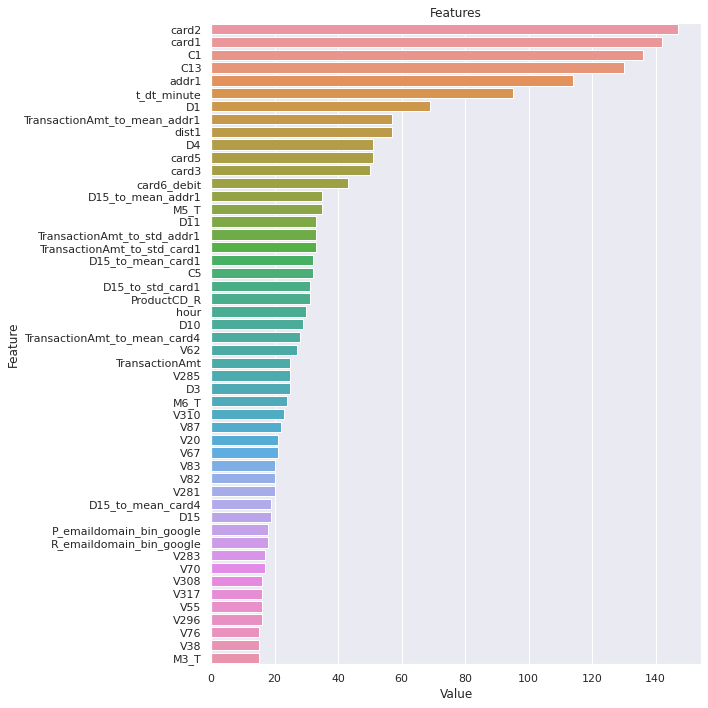

In [85]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_importance(model, features, num=len(X), save=False):

    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:50])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

        
        
plot_importance(reg3, X_train)

In [86]:
predictions3 = reg3.predict_proba(test_df)[:,1]

In [87]:
test_df_son = test_transaction.merge(test_identity, how="left", on="TransactionID")

In [88]:
submission = pd.DataFrame({'TransactionID':test_df_son['TransactionID'],'isFraud':predictions3})
submission["TransactionID"]=submission["TransactionID"].astype(int)
submission.head()

,TransactionID,isFraud
0,3663549,0.047124
1,3663550,0.036306
2,3663551,0.071800
3,3663552,0.022501
4,3663553,0.026749


In [89]:
filename = 'CIS Fraud Detection over sampling lgbm.csv'

submission.to_csv(filename,index=False)

print('Saved file: ' + filename)

Saved file: CIS Fraud Detection over sampling lgbm.csv


In [90]:
# Score: 0.880898
# Public score: 0.903323

# xgb

In [91]:
from sklearn.metrics import classification_report
reg4 = XGBClassifier()   
reg4.fit(X_train_res,y_train_res.ravel()) 

[18:13:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [92]:
pred4 = reg4.predict(X_test)  
print(classification_report(y_test, pred4))
print(f"Auc: {round(roc_auc_score(pred4, y_test), 2)}")

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99    170963
         1.0       0.65      0.72      0.68      6199

    accuracy                           0.98    177162
   macro avg       0.82      0.85      0.83    177162
weighted avg       0.98      0.98      0.98    177162

Auc: 0.82


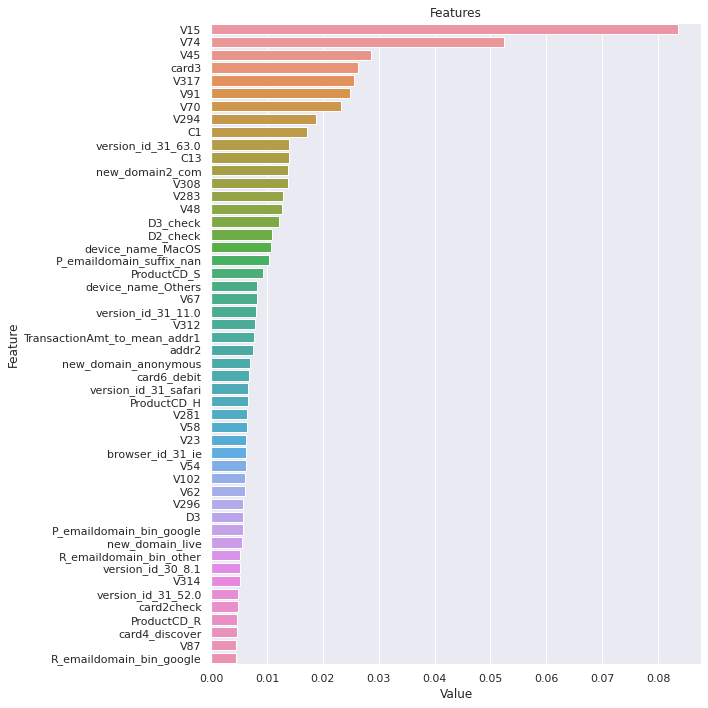

In [93]:
plot_importance(reg4, X_train)

In [94]:
predictions4 = reg4.predict_proba(test_df)[:,1]

In [95]:
test_df_son = test_transaction.merge(test_identity, how="left", on="TransactionID")

In [96]:
submission = pd.DataFrame({'TransactionID':test_df_son['TransactionID'],'isFraud':predictions4})
submission["TransactionID"]=submission["TransactionID"].astype(int)
submission.head()

,TransactionID,isFraud
0,3663549,0.018342
1,3663550,0.040599
2,3663551,0.101710
3,3663552,0.035112
4,3663553,0.026233


In [97]:
filename = 'CIS Fraud Detection sampling xgboost.csv'

submission.to_csv(filename,index=False)

print('Saved file: ' + filename)

Saved file: CIS Fraud Detection sampling xgboost.csv


In [98]:
# Score: 0.863160
# Public score: 0.890700